___
### Notebook 4 - Machine Learning Models - Clustering and Classification
___

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
# Clearing up memory
import gc

# Featuretools for automated feature engineering
import featuretools as ft
ft.__version__

'0.2.1'

# Clustering

In [2]:
df_kaggle_onehot = pd.read_pickle('df_kaggle_onehot')
df_kaggle_onehot.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_EXT_SOURCE_1_N,FLAG_EXT_SOURCE_1_Y,FLAG_EXT_SOURCE_2_N,FLAG_EXT_SOURCE_2_Y,FLAG_EXT_SOURCE_3_N,FLAG_EXT_SOURCE_3_Y,FLAG_SOCIAL_CIRCLE_AVAILABLE_N,FLAG_SOCIAL_CIRCLE_AVAILABLE_Y,FLAG_CREDIT_BUREAU_CHECK_N,FLAG_CREDIT_BUREAU_CHECK_Y
0,100002,1,0,12.218500,12.915581,10.114619,12.768544,0.018801,9.155039,6.458338,...,0,1,0,1,0,1,0,1,0,1
1,100003,0,0,12.506181,14.072865,10.482892,13.937287,0.003541,9.727108,7.080868,...,0,1,0,1,1,0,0,1,0,1
2,100004,0,0,11.119898,11.813037,8.817446,11.813037,0.010032,9.854665,5.420535,...,1,0,0,1,0,1,0,1,0,1
3,100006,0,0,11.813037,12.652947,10.298481,12.601491,0.008019,9.852510,8.019613,...,1,0,0,1,1,0,0,1,1,0
4,100007,0,0,11.707678,13.148033,9.992711,13.148033,0.028663,9.900132,8.019284,...,1,0,0,1,1,0,0,1,0,1


In [10]:
print("Kaggle Dataset Shape:", df_kaggle_onehot.shape)
desc = df_kaggle_onehot.describe(include='all').T
desc['percent_missing'] = (df_kaggle_onehot['SK_ID_CURR'].size - desc['count'])*100/\
    df_kaggle_onehot['SK_ID_CURR'].size
desc = desc[desc['count']<df_kaggle_onehot['SK_ID_CURR'].size][['count','percent_missing']]
print("Cleaned_Application_Data has {} columns with missing data out of total {} columns".format(desc.shape[0], 
      df_kaggle_onehot.columns.size))

Kaggle Dataset Shape: (356255, 1925)
Cleaned_Application_Data has 0 columns with missing data out of total 1925 columns


In [3]:
# Separate the Kaggle train and kaggle test datasets from df_kaggle dataset
df_kaggle_train = df_kaggle_onehot[df_kaggle_onehot.TARGET !=- 1]
df_kaggle_test = df_kaggle_onehot[df_kaggle_onehot.TARGET == -1]
print(df_kaggle_train.shape, df_kaggle_test.shape)
kaggle_samp = df_kaggle_train.sample(frac=0.1)
x_kaggle_samp = kaggle_samp.drop(['SK_ID_CURR', 'TARGET'], axis=1)

(307511, 1925) (48744, 1925)


In [4]:
X_kaggle_test = df_kaggle_test.drop(['SK_ID_CURR', 'TARGET'], axis=1).values

In [5]:
x_kaggle_samp.shape

(30751, 1923)

In [14]:
from sklearn.cluster import MiniBatchKMeans

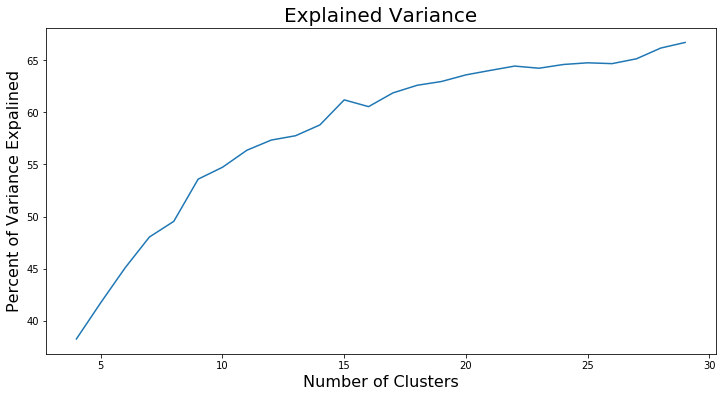

In [15]:
from scipy.spatial.distance import cdist, pdist

cluster_range = range(4,30)
cluster_errors = []


mbkVar = [MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0).fit(x_kaggle_samp) for k in cluster_range]

centroids = [X.cluster_centers_ for X in mbkVar]
cluster_errors = [X.inertia_ for X in mbkVar]
k_euclid = [cdist(x_kaggle_samp, cent) for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(x_kaggle_samp)**2)/x_kaggle_samp.shape[0]
bss = tss - wcss
plt.figure(figsize=(12,6))
plt.plot(cluster_range, bss/tss*100)
plt.title('Explained Variance', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Percent of Variance Expalined', fontsize=16)
plt.show()

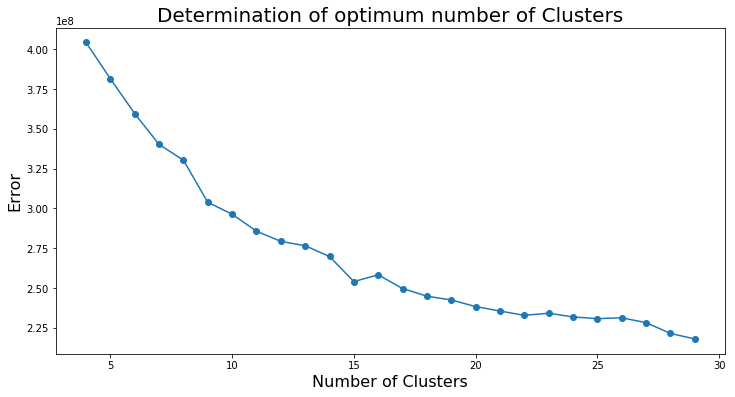

In [16]:
clusters_df  = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.title('Determination of optimum number of Clusters', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.show()

In [17]:
kmean_model = mbkVar[5]
kmean_model

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=9,
        n_init=10, random_state=0, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [18]:
# from sklearn.preprocessing import StandardScaler
feature_cluster = pd.DataFrame(kmean_model.transform(df_kaggle_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)))
# feature_cluster = pd.DataFrame(StandardScaler().fit_transform(feature_cluster))
cluster_col_name = []
for i in range(1,10):
    cluster_col_name.append("Cluster_" + str(i))
feature_cluster.columns = cluster_col_name
feature_cluster.head()

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,98.688800,149.433045,184.197616,82.065371,185.161628,227.208125,143.304664,297.306979,78.614799
1,98.213405,140.159044,183.560322,89.917083,113.559779,225.422850,154.444398,292.925540,45.054043
2,109.475307,148.790572,189.667420,101.434433,125.990794,231.190529,142.810207,299.079029,52.737059
3,149.616595,170.395814,158.283722,92.152750,205.587782,206.880466,159.029931,281.555634,125.619118
4,168.287742,69.227553,217.142572,143.006340,179.841261,182.631639,196.074018,277.017723,154.403341


In [19]:
print(feature_cluster.shape, df_kaggle_train.shape)

(307511, 9) (307511, 1925)


In [20]:
feature_cluster = df_kaggle_train[['SK_ID_CURR', 'TARGET']].join(feature_cluster)

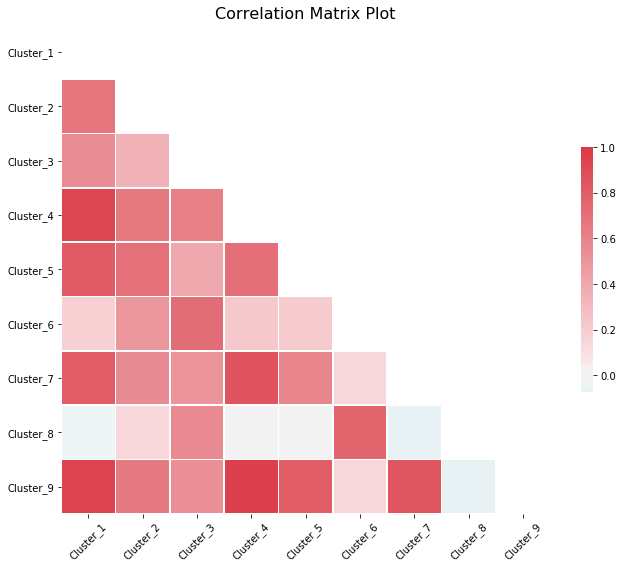

In [21]:
import seaborn as sns
corr = feature_cluster.drop(['SK_ID_CURR','TARGET'], axis=1).corr()

# plot correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Correlation Matrix Plot", fontsize=16)
plt.show()

In [22]:
predict_cluster = pd.DataFrame(kmean_model.predict(df_kaggle_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)))
predict_cluster[0] = predict_cluster[0].astype('category')
predict_cluster = pd.get_dummies(predict_cluster)
cluster_col_name = []
for i in range(1,10):
    cluster_col_name.append("Cluster_" + str(i))
predict_cluster.columns = cluster_col_name

predict_cluster = df_kaggle_train[['SK_ID_CURR', 'TARGET']].join(predict_cluster)
predict_cluster.head(10)

,SK_ID_CURR,TARGET,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,100002,1,0,0,0,0,0,0,0,0,1
1,100003,0,0,0,0,0,0,0,0,0,1
2,100004,0,0,0,0,0,0,0,0,0,1
3,100006,0,0,0,0,1,0,0,0,0,0
4,100007,0,0,1,0,0,0,0,0,0,0
5,100008,0,0,1,0,0,0,0,0,0,0
6,100009,0,0,0,0,1,0,0,0,0,0
7,100010,0,0,0,0,0,0,0,0,0,1
8,100011,0,0,0,0,0,0,0,0,1,0
9,100012,0,0,0,0,0,0,0,0,0,1


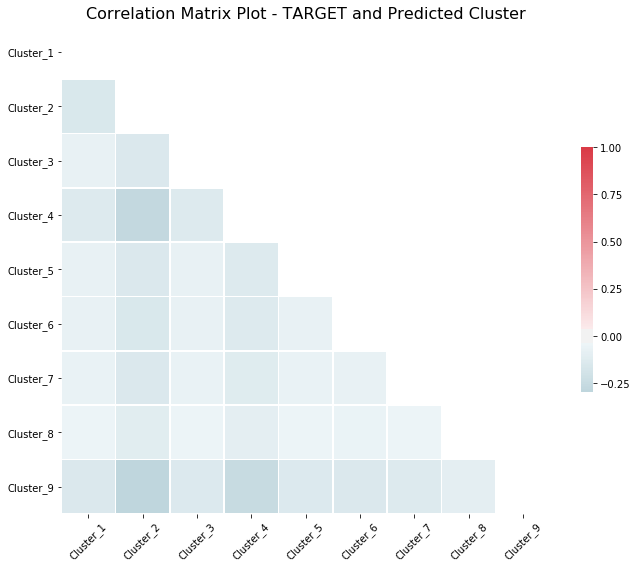

In [23]:
corr = predict_cluster.drop(['SK_ID_CURR','TARGET'], axis=1).corr()

# plot correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Correlation Matrix Plot - TARGET and Predicted Cluster", fontsize=16)
plt.show()

# Classification evaluation function

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy
import pandas as pd
import itertools

def classification_evaluation(y_actual, y_prediction, y_prediction_prob, pr_roc_ind=1):
    """
    Implementation of classification_evaluation which is for implementaion of creation of confusion matrix and 
    ROC/PR curve.
        
    Arguments:
    y_actual -- Actual values of the variable to be predicted
    y_prediction -- Predicted values of the variable to be predicted
    y_prediction_prob -- Prediction probabilities with predicted values of the variable to be predicted
    pr_roc_ind -- Indicator to determine whether to create PR curve or ROC curve. If 1 then PR curve else ROC curve.
       
    Returns:
    """
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_actual, y_prediction)
    np.set_printoptions(precision=2)
    print("Detailed classification report:\n")
    print(classification_report(y_actual, y_prediction))
    print('Accuracy:', accuracy_score(y_actual, y_prediction))
    print('Weighted F1 score:', f1_score(y_actual, y_prediction, average='weighted'))
    
    fig, ax = plt.subplots(1,2, figsize=(14, 6))
    # Plot confusion matrix
    ax[0] = plot_confusion_matrix(cnf_matrix, classes=[0,1], threshold=0.5, plt_axis=ax[0])
    ax[0].set_title('Confusion Matrix')

    if pr_roc_ind==1:
        # calculate the fpr and tpr for all thresholds of the classification
        precision, recall, threshold = precision_recall_curve(y_actual, y_prediction_prob[:,1])
        # Plot PR Curve    
        ax[1] = plot_precision_recall_curve(precision, recall, plt_axis=ax[1])
        average_precision = average_precision_score(y_actual, y_prediction)
        ax[1].set_title("PR Curve:Average precision-recall score: {0:0.2f}".format(average_precision) )
    
    else:
        # calculate the fpr and tpr for all thresholds of the classification
        fpr, tpr, threshold = roc_curve(y_actual, y_prediction_prob[:,1])
        # Plot ROC Curve    
        ax[1] = plot_roc_curve(fpr, tpr, plt_axis=ax[1])
        ax[1].set_title("ROC Curve")
    
    plt.subplots_adjust( wspace=0.2)
    plt.show()
    
def plot_confusion_matrix(cm, classes, plt_axis, 
                          threshold = 0,
                          cmap=plt.cm.Blues ):
    """
    This function prints and plots the confusion matrix.
    """
    cm1 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.sca(plt_axis)
    plt.imshow(cm1, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm1.max() / 4 if threshold==0 else threshold
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt_axis.text(j, i, format(cm[i, j], fmt)+'\nNormalized:' + format(cm1[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm1[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt_axis

def plot_roc_curve(fpr, tpr, plt_axis):
    roc_auc = auc(fpr, tpr) # Area under curve
    plt.sca(plt_axis)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return plt_axis

def plot_precision_recall_curve(precision, recall, plt_axis):
    pr_auc = auc(recall, precision) # Area under curve
    plt.sca(plt_axis)
    plt.step(recall, precision, color='b', alpha=0.2, where='post', label = 'AUC = %0.2f' % pr_auc)
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.legend(loc = 'lower right')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    return plt_axis

In [25]:
# df_kaggle_test.to_csv()
def generate_kaggle_output(model, test_data, df_test_SK_ID, csv_file_name):
    df_test_SK_ID['TARGET']= model.predict(test_data)
    df_test_SK_ID.to_csv(index=False, path_or_buf = 'output/' + csv_file_name + '.csv')

# Perform Classification with clustering information


Random Forest Execution with clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     56538
          1       0.12      0.01      0.01      4965

avg / total       0.86      0.92      0.88     61503

Accuracy: 0.9159390598832577
Weighted F1 score: 0.8799345606061487


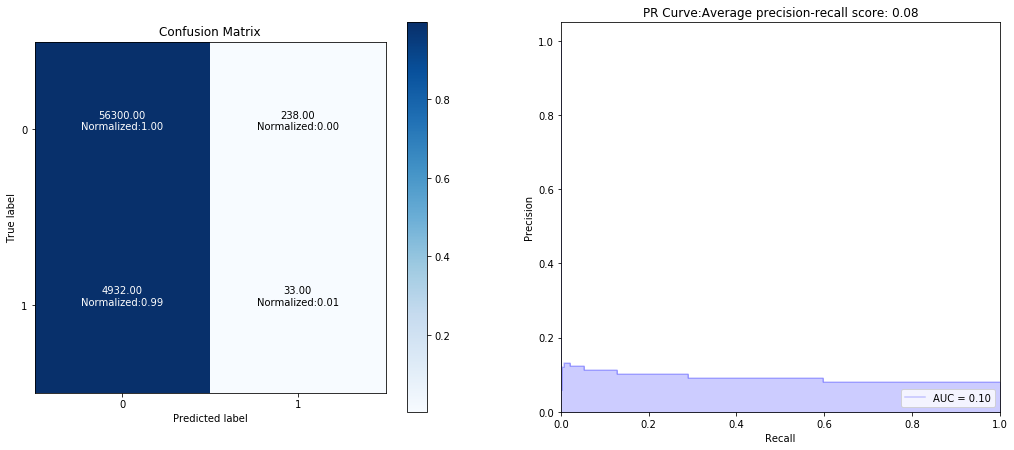

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
X = feature_cluster.drop(['SK_ID_CURR', 'TARGET'], axis=1).values
Y = feature_cluster['TARGET']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
count = 1
print("")
for train_index, test_index in sss.split(X, Y):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    
    rfc = RandomForestClassifier()
    rfc.fit(X_train, Y_train.ravel())
    y_pred = rfc.predict(X_test)
    pred_prob = rfc.predict_proba(X_test)
    print("Random Forest Execution with clustered data: ")
    classification_evaluation(Y_test, y_pred, pred_prob)

generate_kaggle_output(rfc, kmean_model.transform(X_kaggle_test),
    pd.DataFrame(df_kaggle_test.SK_ID_CURR), "Cluster_dist_RandomForest" )


Random Forest Execution with clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.93      0.64      0.76     56538
          1       0.10      0.48      0.17      4965

avg / total       0.87      0.62      0.71     61503

Accuracy: 0.6232378908345935
Weighted F1 score: 0.70897903565026


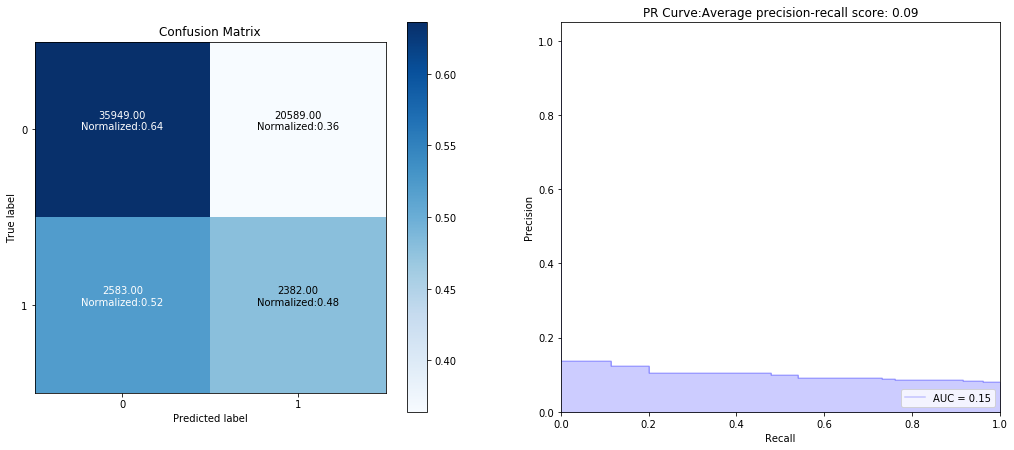

In [33]:
X = predict_cluster.drop(['SK_ID_CURR', 'TARGET'], axis=1).values
Y = predict_cluster['TARGET']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
count = 1
print("")
for train_index, test_index in sss.split(X, Y):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    
    rfc = RandomForestClassifier(class_weight='balanced')
    rfc.fit(X_train, Y_train.ravel())
    y_pred = rfc.predict(X_test)
    pred_prob = rfc.predict_proba(X_test)
    print("Random Forest Execution with clustered data: ")
    classification_evaluation(Y_test, y_pred, pred_prob)
generate_kaggle_output(rfc, pd.get_dummies(kmean_model.predict(X_kaggle_test)),
    pd.DataFrame(df_kaggle_test.SK_ID_CURR), "Cluster_nbr_RandomForest" )


Training until validation scores don't improve for 5000 rounds.
[100]	valid_0's auc: 0.678492	valid_1's auc: 0.609948
[200]	valid_0's auc: 0.71495	valid_1's auc: 0.608902
[300]	valid_0's auc: 0.742043	valid_1's auc: 0.607665
[400]	valid_0's auc: 0.763794	valid_1's auc: 0.606684
[500]	valid_0's auc: 0.783473	valid_1's auc: 0.604583
[600]	valid_0's auc: 0.800713	valid_1's auc: 0.603322
[700]	valid_0's auc: 0.815451	valid_1's auc: 0.602535
[800]	valid_0's auc: 0.828681	valid_1's auc: 0.600725
[900]	valid_0's auc: 0.840486	valid_1's auc: 0.599127
[1000]	valid_0's auc: 0.850594	valid_1's auc: 0.596808
[1100]	valid_0's auc: 0.86059	valid_1's auc: 0.595008
[1200]	valid_0's auc: 0.869391	valid_1's auc: 0.594164
[1300]	valid_0's auc: 0.877714	valid_1's auc: 0.593737
[1400]	valid_0's auc: 0.885219	valid_1's auc: 0.592742
[1500]	valid_0's auc: 0.892243	valid_1's auc: 0.591562
[1600]	valid_0's auc: 0.898779	valid_1's auc: 0.590665
[1700]	valid_0's auc: 0.90452	valid_1's auc: 0.590099
[1800]	valid

/home/hnsanadhya_08/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Light Gradient Boosting Machine with clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.93      0.83      0.88     56538
          1       0.12      0.25      0.16      4965

avg / total       0.86      0.79      0.82     61503

Accuracy: 0.7852950262588817
Weighted F1 score: 0.8189140317266381


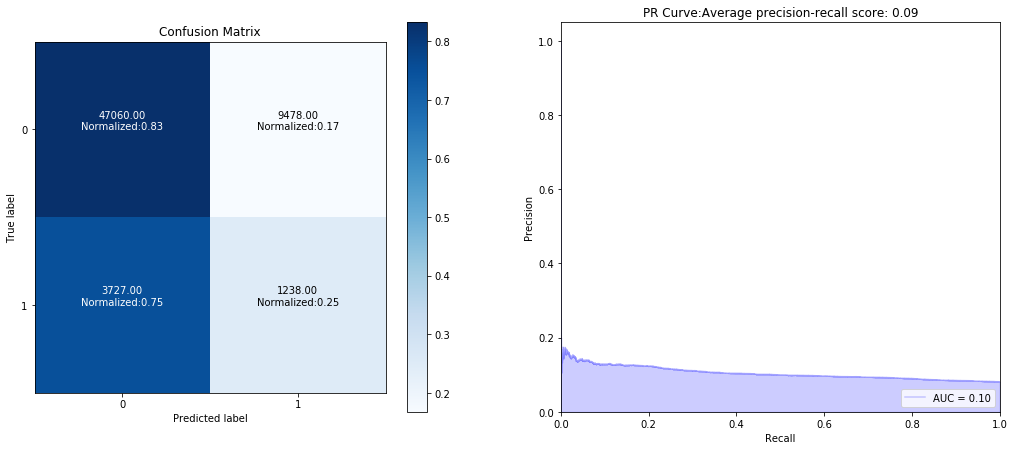

/home/hnsanadhya_08/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
from lightgbm import LGBMClassifier

X = feature_cluster.drop(['SK_ID_CURR', 'TARGET'], axis=1).values
Y = feature_cluster['TARGET']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
count = 1
print("")
for train_index, test_index in sss.split(X, Y):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    # LightGBM parameters 
    clf = LGBMClassifier(class_weight = 'balanced', boosting_type = 'goss', n_estimators=5000)
    
    
    clf.fit(X_train, Y_train.ravel(), eval_set=[(X_train, Y_train.ravel()), (X_test, Y_test)], 
        eval_metric= 'auc', verbose= 100, early_stopping_rounds= 5000)

    pred_prob = clf.predict_proba(X_test)
    predictions = clf.predict(X_test)
    
    print("\nLight Gradient Boosting Machine with clustered data: ")
    classification_evaluation(Y_test, predictions, pred_prob)
generate_kaggle_output(clf, kmean_model.transform(X_kaggle_test),
    pd.DataFrame(df_kaggle_test.SK_ID_CURR), "Cluster_dist_lgbm" )


Training until validation scores don't improve for 5000 rounds.
[100]	valid_0's auc: 0.677441	valid_1's auc: 0.611085
[200]	valid_0's auc: 0.7136	valid_1's auc: 0.609149
[300]	valid_0's auc: 0.741626	valid_1's auc: 0.608086
[400]	valid_0's auc: 0.763851	valid_1's auc: 0.606014
[500]	valid_0's auc: 0.784198	valid_1's auc: 0.60436
[600]	valid_0's auc: 0.800855	valid_1's auc: 0.603444
[700]	valid_0's auc: 0.81637	valid_1's auc: 0.603307
[800]	valid_0's auc: 0.829132	valid_1's auc: 0.601856
[900]	valid_0's auc: 0.84097	valid_1's auc: 0.601073
[1000]	valid_0's auc: 0.852313	valid_1's auc: 0.601388
[1100]	valid_0's auc: 0.86207	valid_1's auc: 0.599496
[1200]	valid_0's auc: 0.870571	valid_1's auc: 0.598092
[1300]	valid_0's auc: 0.878799	valid_1's auc: 0.596664
[1400]	valid_0's auc: 0.886217	valid_1's auc: 0.59594
[1500]	valid_0's auc: 0.892953	valid_1's auc: 0.594714
[1600]	valid_0's auc: 0.899421	valid_1's auc: 0.593505
[1700]	valid_0's auc: 0.905326	valid_1's auc: 0.592425
[1800]	valid_0's

/home/hnsanadhya_08/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Light Gradient Boosting Machine with clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.93      0.83      0.88     56538
          1       0.12      0.26      0.16      4965

avg / total       0.86      0.79      0.82     61503

Accuracy: 0.7868721850966619
Weighted F1 score: 0.8201887792431694


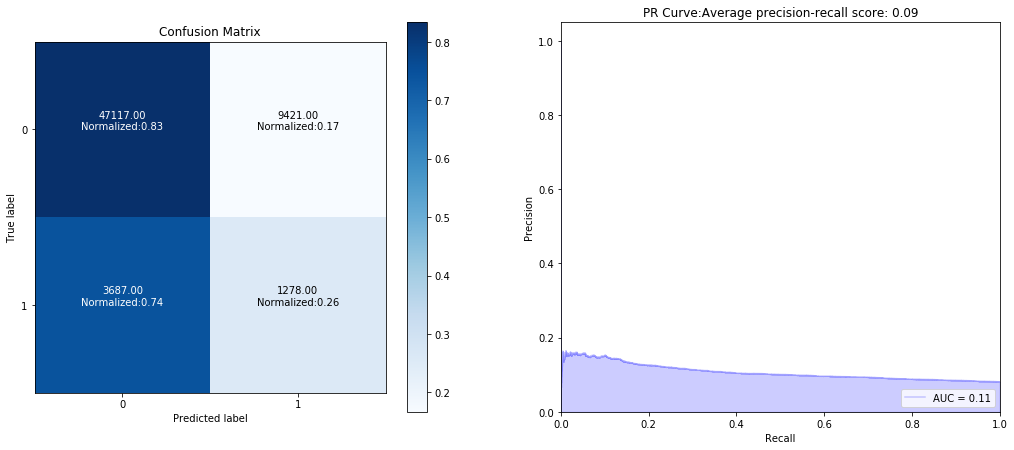

/home/hnsanadhya_08/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [38]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X = ss.fit_transform(feature_cluster.drop(['SK_ID_CURR','TARGET'], axis=1))
Y = feature_cluster['TARGET']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
count = 1
print("")
for train_index, test_index in sss.split(X, Y):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    # LightGBM parameters 
    std_clf = LGBMClassifier(class_weight = 'balanced', boosting_type = 'goss', n_estimators=5000)
    
    
    std_clf.fit(X_train, Y_train.ravel(), eval_set=[(X_train, Y_train.ravel()), (X_test, Y_test)], 
        eval_metric= 'auc', verbose= 100, early_stopping_rounds= 5000)

    pred_prob = std_clf.predict_proba(X_test)
    predictions = std_clf.predict(X_test)
    
    print("\nLight Gradient Boosting Machine with clustered data: ")
    classification_evaluation(Y_test, predictions, pred_prob)

generate_kaggle_output(std_clf, ss.transform(pd.get_dummies(kmean_model.predict(X_kaggle_test))),
    pd.DataFrame(df_kaggle_test.SK_ID_CURR), "std_Cluster_dist_lgbm" )


Random Forest Execution with clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.92      0.89      0.91     56538
          1       0.11      0.16      0.13      4965

avg / total       0.86      0.83      0.84     61503

Accuracy: 0.8312765230964343
Weighted F1 score: 0.8440684982773833


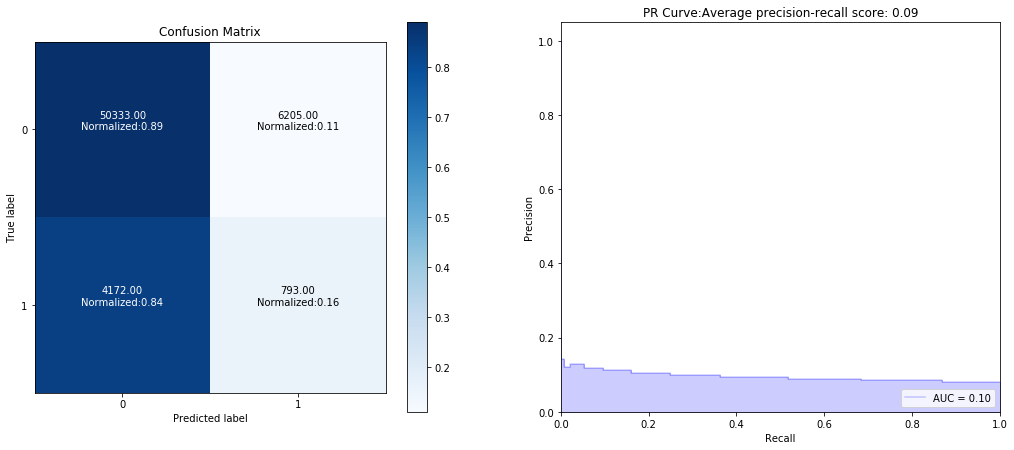


Decision Tree Execution with clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.92      0.79      0.85     56538
          1       0.09      0.25      0.14      4965

avg / total       0.86      0.75      0.79     61503

Accuracy: 0.745768499097605
Weighted F1 score: 0.7933125485786044


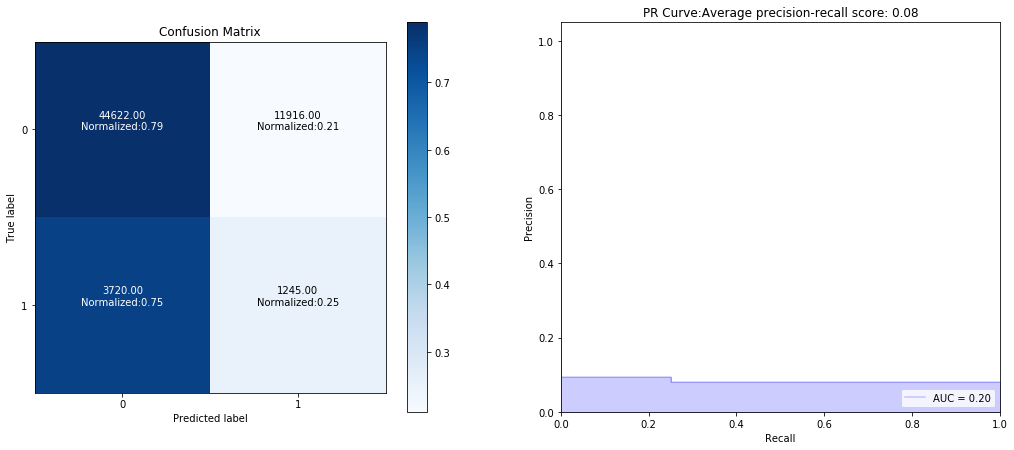

Training until validation scores don't improve for 5000 rounds.
[100]	valid_0's auc: 0.67766	valid_1's auc: 0.607386
[200]	valid_0's auc: 0.710775	valid_1's auc: 0.60428
[300]	valid_0's auc: 0.733941	valid_1's auc: 0.603213
[400]	valid_0's auc: 0.751935	valid_1's auc: 0.601424
[500]	valid_0's auc: 0.766651	valid_1's auc: 0.599918
[600]	valid_0's auc: 0.779242	valid_1's auc: 0.598296
[700]	valid_0's auc: 0.790046	valid_1's auc: 0.595798
[800]	valid_0's auc: 0.800035	valid_1's auc: 0.59404
[900]	valid_0's auc: 0.808673	valid_1's auc: 0.593285
[1000]	valid_0's auc: 0.816874	valid_1's auc: 0.591324
[1100]	valid_0's auc: 0.824321	valid_1's auc: 0.589319
[1200]	valid_0's auc: 0.830761	valid_1's auc: 0.588581
[1300]	valid_0's auc: 0.836826	valid_1's auc: 0.587973
[1400]	valid_0's auc: 0.843059	valid_1's auc: 0.587497
[1500]	valid_0's auc: 0.847968	valid_1's auc: 0.586878
[1600]	valid_0's auc: 0.852564	valid_1's auc: 0.585928
[1700]	valid_0's auc: 0.857057	valid_1's auc: 0.584535
[1800]	valid_

/home/hnsanadhya_08/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Light Gradient Boosting Machine with clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.93      0.76      0.84     56538
          1       0.11      0.33      0.16      4965

avg / total       0.86      0.73      0.78     61503

Accuracy: 0.7278344145814025
Weighted F1 score: 0.7830696563227566


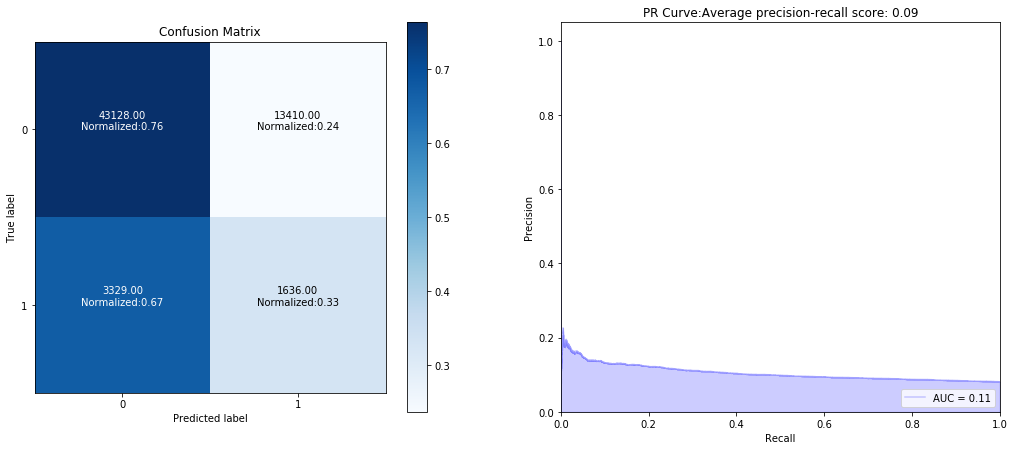

/home/hnsanadhya_08/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [39]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

X = feature_cluster.drop(['SK_ID_CURR', 'TARGET'], axis=1).values
Y = feature_cluster['TARGET']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
count = 1
print("")
for train_index, test_index in sss.split(X, Y):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    sm = SMOTE( n_jobs=4)
    x_train_res, y_train_res = sm.fit_sample(X_train, Y_train.ravel())
    rfc = RandomForestClassifier()
    rfc.fit(x_train_res, y_train_res.ravel())
    y_pred = rfc.predict(X_test)
    pred_prob = rfc.predict_proba(X_test)
    print("Random Forest Execution with clustered data: ")
    classification_evaluation(Y_test, y_pred, pred_prob)
    generate_kaggle_output(rfc, kmean_model.transform(X_kaggle_test),
        pd.DataFrame(df_kaggle_test.SK_ID_CURR), "oversampled_Cluster_dist_RandomForest" )
    
    dtc = DecisionTreeClassifier()
    dtc.fit(x_train_res, y_train_res.ravel())
    y_pred = dtc.predict(X_test)
    pred_prob = dtc.predict_proba(X_test)
    print("\nDecision Tree Execution with clustered data: ")
    classification_evaluation(Y_test, y_pred, pred_prob)
    generate_kaggle_output(dtc, kmean_model.transform(X_kaggle_test),
        pd.DataFrame(df_kaggle_test.SK_ID_CURR), "oversampled_Cluster_dist_DecisionTree" )
    
    # LightGBM parameters 
    clf = LGBMClassifier(boosting_type = 'goss', n_estimators=5000)

    clf.fit(x_train_res, y_train_res.ravel(), eval_set=[(x_train_res, y_train_res.ravel()), (X_test, Y_test)], 
        eval_metric= 'auc', verbose= 100, early_stopping_rounds= 5000)

    pred_prob = clf.predict_proba(X_test)
    predictions = clf.predict(X_test)
    
    print("\nLight Gradient Boosting Machine with clustered data: ")
    classification_evaluation(Y_test, predictions, pred_prob)

    generate_kaggle_output(clf, kmean_model.transform(X_kaggle_test),
        pd.DataFrame(df_kaggle_test.SK_ID_CURR), "oversampled_Cluster_dist_lgbm" )


Random Forest Execution with standardized clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.92      0.89      0.91     56538
          1       0.11      0.16      0.13      4965

avg / total       0.86      0.83      0.84     61503

Accuracy: 0.8292278425442662
Weighted F1 score: 0.8427246196894157


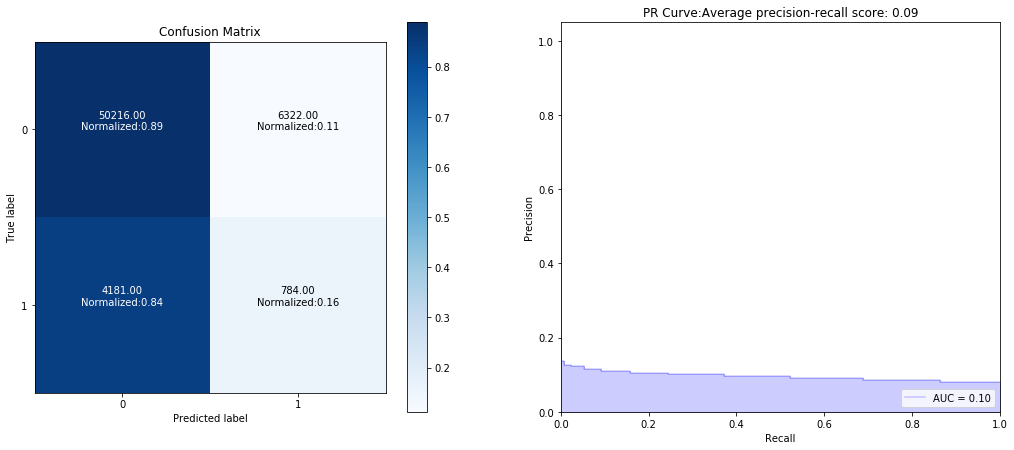


Decision Tree Execution with standardized clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.93      0.79      0.85     56538
          1       0.10      0.27      0.15      4965

avg / total       0.86      0.75      0.80     61503

Accuracy: 0.7509227192169488
Weighted F1 score: 0.7972092451275066


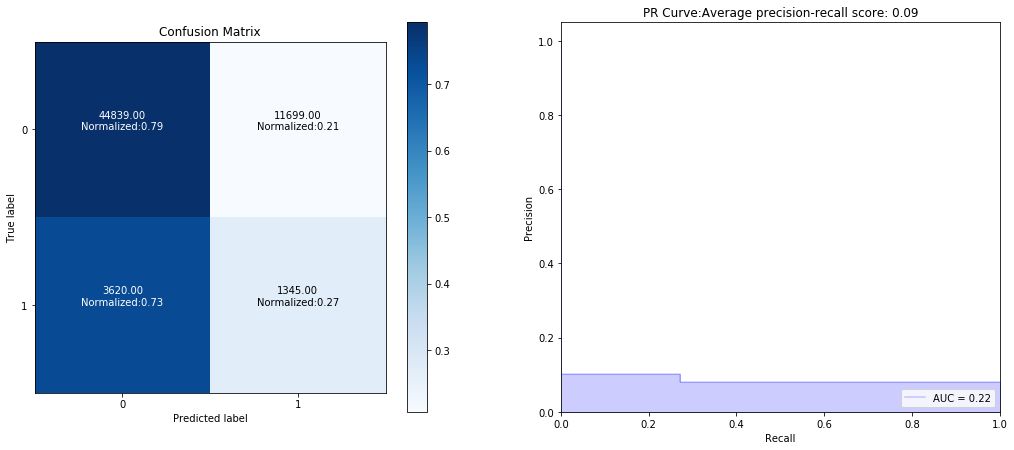

Training until validation scores don't improve for 5000 rounds.
[100]	valid_0's auc: 0.677962	valid_1's auc: 0.60581
[200]	valid_0's auc: 0.709998	valid_1's auc: 0.60428
[300]	valid_0's auc: 0.733476	valid_1's auc: 0.604214
[400]	valid_0's auc: 0.751874	valid_1's auc: 0.60136
[500]	valid_0's auc: 0.766881	valid_1's auc: 0.599549
[600]	valid_0's auc: 0.779707	valid_1's auc: 0.598355
[700]	valid_0's auc: 0.790722	valid_1's auc: 0.596059
[800]	valid_0's auc: 0.800576	valid_1's auc: 0.594292
[900]	valid_0's auc: 0.809171	valid_1's auc: 0.593109
[1000]	valid_0's auc: 0.817323	valid_1's auc: 0.590367
[1100]	valid_0's auc: 0.824379	valid_1's auc: 0.589328
[1200]	valid_0's auc: 0.831397	valid_1's auc: 0.587143
[1300]	valid_0's auc: 0.837576	valid_1's auc: 0.586114
[1400]	valid_0's auc: 0.843391	valid_1's auc: 0.584819
[1500]	valid_0's auc: 0.848274	valid_1's auc: 0.584768
[1600]	valid_0's auc: 0.853487	valid_1's auc: 0.582808
[1700]	valid_0's auc: 0.858157	valid_1's auc: 0.581997
[1800]	valid_

/home/hnsanadhya_08/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Light Gradient Boosting Machine with standardized clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.93      0.76      0.84     56538
          1       0.11      0.32      0.16      4965

avg / total       0.86      0.73      0.78     61503

Accuracy: 0.7281921207095589
Weighted F1 score: 0.7832154746277128


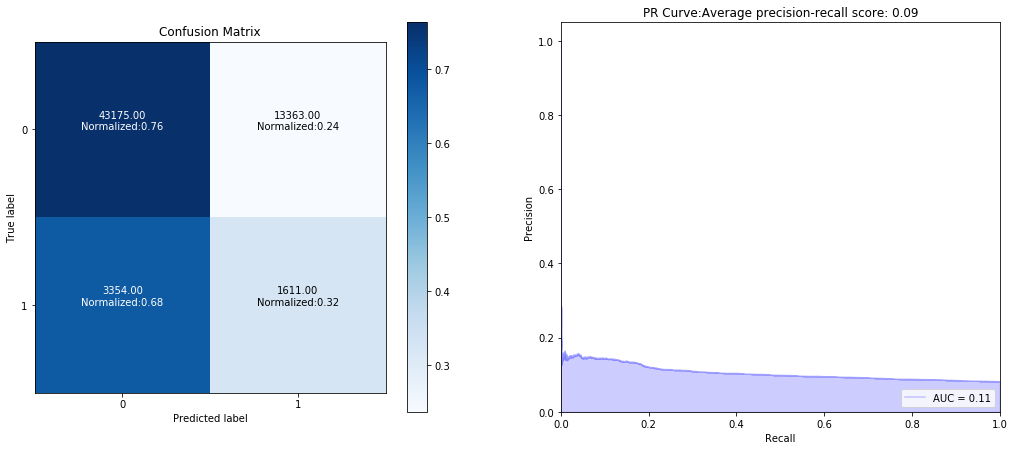

/home/hnsanadhya_08/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [41]:
from sklearn.preprocessing import StandardScaler

ss_trans = StandardScaler()

X = ss_trans.fit_transform(feature_cluster.drop(['SK_ID_CURR','TARGET'], axis=1))
Y = feature_cluster['TARGET']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
count = 1
print("")
for train_index, test_index in sss.split(X, Y):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    sm = SMOTE( n_jobs=4)
    x_train_res, y_train_res = sm.fit_sample(X_train, Y_train.ravel())
    rfc_std = RandomForestClassifier()
    rfc_std.fit(x_train_res, y_train_res.ravel())
    y_pred = rfc_std.predict(X_test)
    pred_prob = rfc_std.predict_proba(X_test)
    print("Random Forest Execution with standardized clustered data: ")
    classification_evaluation(Y_test, y_pred, pred_prob)
    generate_kaggle_output(rfc_std, ss_trans.transform(kmean_model.transform(X_kaggle_test)),
        pd.DataFrame(df_kaggle_test.SK_ID_CURR), "Standardized_oversampled_Cluster_dist_randomforest" )
    
    dtc_std = DecisionTreeClassifier()
    dtc_std.fit(x_train_res, y_train_res.ravel())
    y_pred = dtc_std.predict(X_test)
    pred_prob = dtc_std.predict_proba(X_test)
    print("\nDecision Tree Execution with standardized clustered data: ")
    classification_evaluation(Y_test, y_pred, pred_prob)
    generate_kaggle_output(dtc_std, ss_trans.transform(kmean_model.transform(X_kaggle_test)),
        pd.DataFrame(df_kaggle_test.SK_ID_CURR), "Standardized_oversampled_Cluster_dist_DecisionTree" )
    
    # LightGBM parameters 
    clf_std = LGBMClassifier(boosting_type = 'goss', n_estimators=5000)

    clf_std.fit(x_train_res, y_train_res.ravel(), eval_set=[(x_train_res, y_train_res.ravel()), (X_test, Y_test)], 
        eval_metric= 'auc', verbose= 100, early_stopping_rounds= 5000)

    pred_prob = clf_std.predict_proba(X_test)
    predictions = clf_std.predict(X_test)
    
    print("\nLight Gradient Boosting Machine with standardized clustered data: ")
    classification_evaluation(Y_test, predictions, pred_prob)
    generate_kaggle_output(clf_std, ss_trans.transform(kmean_model.transform(X_kaggle_test)),
        pd.DataFrame(df_kaggle_test.SK_ID_CURR), "Standardized_oversampled_Cluster_dist_lgbm" )

In [19]:
kaggle_sample = df_kaggle_train.sample(frac=0.01)
x_kaggle_sample = kaggle_sample.drop(['SK_ID_CURR', 'TARGET'], axis=1).values.tolist()
np.shape(x_kaggle_sample)

(3075, 1923)

In [44]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=0.05, min_samples=1000).fit(x_kaggle_sample)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x_kaggle_sample, labels))

Estimated number of clusters: 0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

scalar = StandardScaler()
# Compute DBSCAN
db = DBSCAN(eps=0.05, min_samples=1000).fit(scalar.fit_transform(x_kaggle_sample))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(scalar.transform(x_kaggle_sample), labels))

Estimated number of clusters: 0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

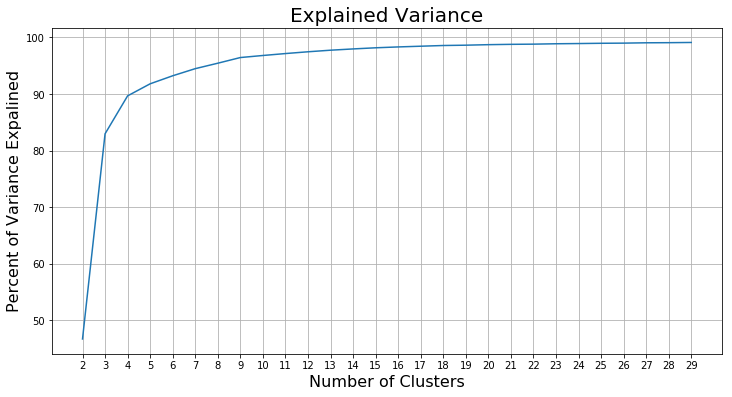

In [43]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

cluster_range = range(2,30)
cluster_errors = []

pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(x_kaggle_sample)
mbkVar = [KMeans(init='k-means++', n_clusters=k, max_iter=500).fit(plot_columns) for k in cluster_range]

centroids = [X.cluster_centers_ for X in mbkVar]
cluster_errors = [X.inertia_ for X in mbkVar]
k_euclid = [cdist(plot_columns, cent) for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(plot_columns)**2)/plot_columns.shape[0]
bss = tss - wcss
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(cluster_range, bss/tss*100)
plt.title('Explained Variance', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Percent of Variance Expalined', fontsize=16)
plt.xticks(cluster_range)
plt.show()

For n_clusters = 4 The average silhouette_score is : 0.27643889165554114


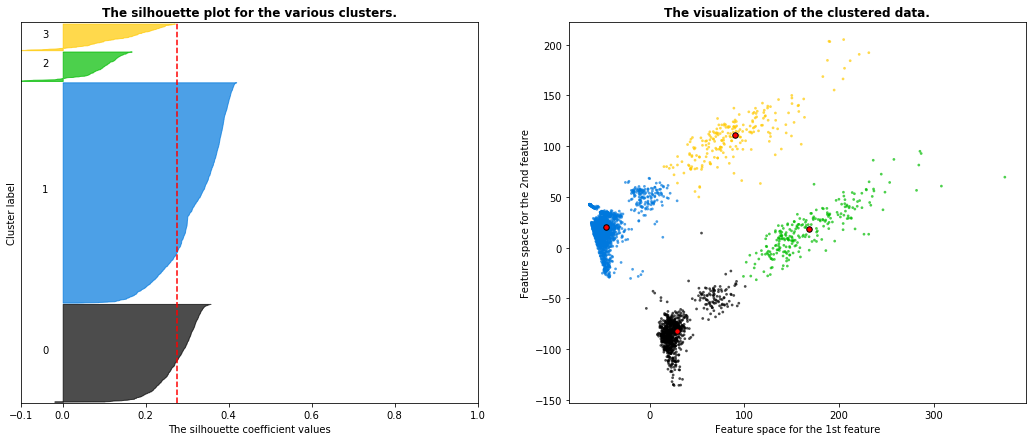

In [47]:
range_n_clusters = [4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_kaggle_sample) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)

    cluster_labels = clusterer.fit_predict(plot_columns)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_kaggle_sample, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_kaggle_sample, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontweight='bold')
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    
    ax2.scatter(x=plot_columns[:,0], y=plot_columns[:,1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="red", alpha=1, s=30, edgecolor='k')


    ax2.set_title("The visualization of the clustered data.", fontweight='bold')
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.show()